In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(cowplot)
})
theme_set(theme_cowplot())
options(repr.plot.width=9, repr.plot.height=9)

# Star polygons

`ggplot2` is a R package for making data graphics, it is known for how flexible and composable the plots are, with its syntax based on the grammar of graphics.

Star polygon is a type of non-convex polygon that looks like a star, in this post, we will be focused on the subset of unicursal star polygons.

Unicursal means that the star can be drawn as a single continuous line, "without lifting the pen from the paper".

To get started, first, we need a set of points around a circle to play with:

In [2]:
circle_points <- function(N) {
	tibble(
        N=N,
        p=1:N,
        x=cos(2*pi*p/N),
        y=sin(2*pi*p/N)
    )
}

Here we defined a function that returns a data frame, each row of the data frame contains a point on the circumference of a circle, 

using a bit of trigonometry, we convert radian angles to cartesian coordinates, which we will use to plot.

In [3]:
circle_points(5)

N,p,x,y
<dbl>,<int>,<dbl>,<dbl>
5,1,0.309016994374947,9.51056516295154e-01
5,2,-0.809016994374947,5.87785252292473e-01
5,3,-0.809016994374948,-5.87785252292473e-01
5,4,0.309016994374947,-9.51056516295154e-01
5,5,1.000000000000000,-2.44929359829471e-16


with these coordinates, we can plot our points:

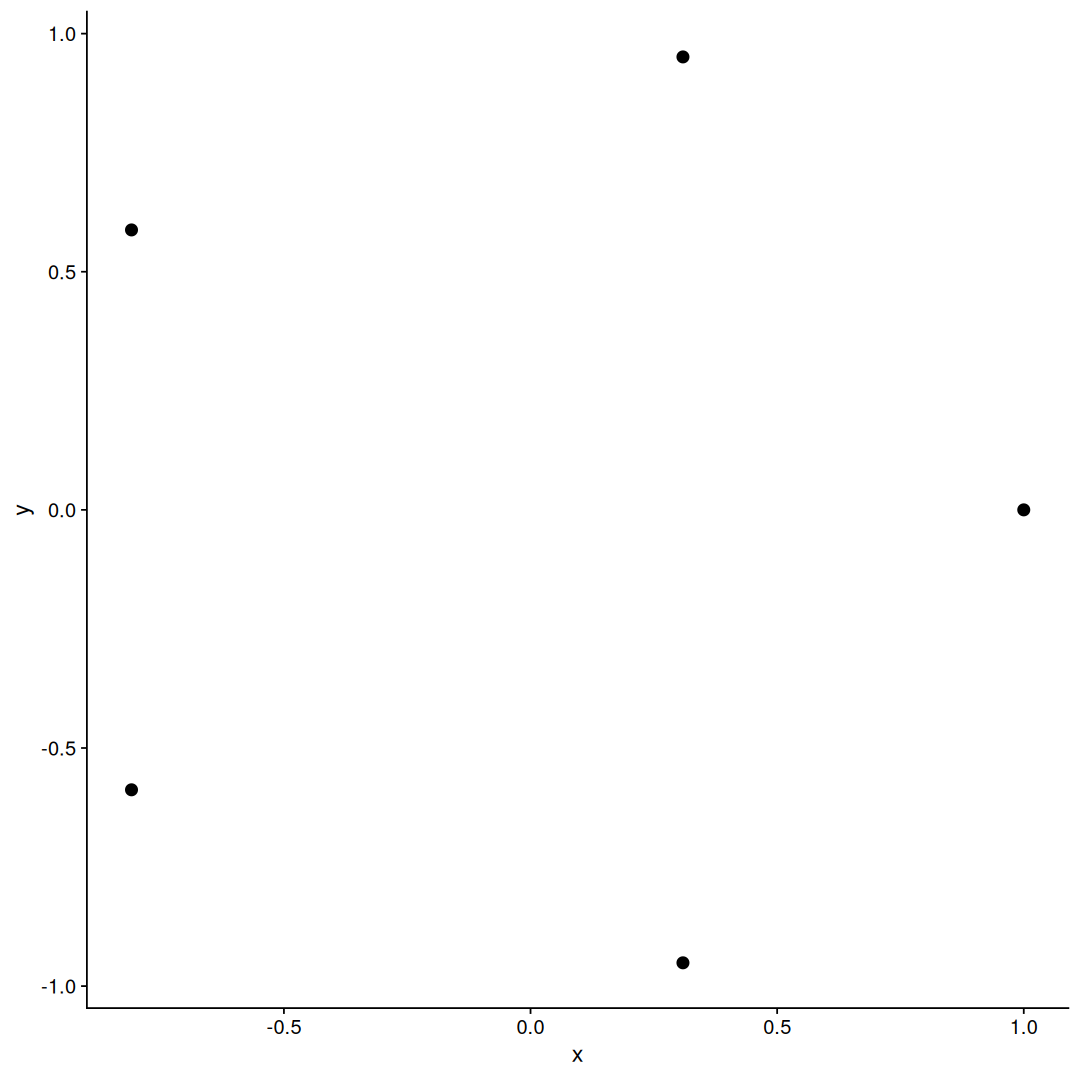

In [4]:
circle_points(5) |>
ggplot(aes(x,y)) +
geom_point(size=3)

If we increase the number of points, they spread around the circumference, as expected:

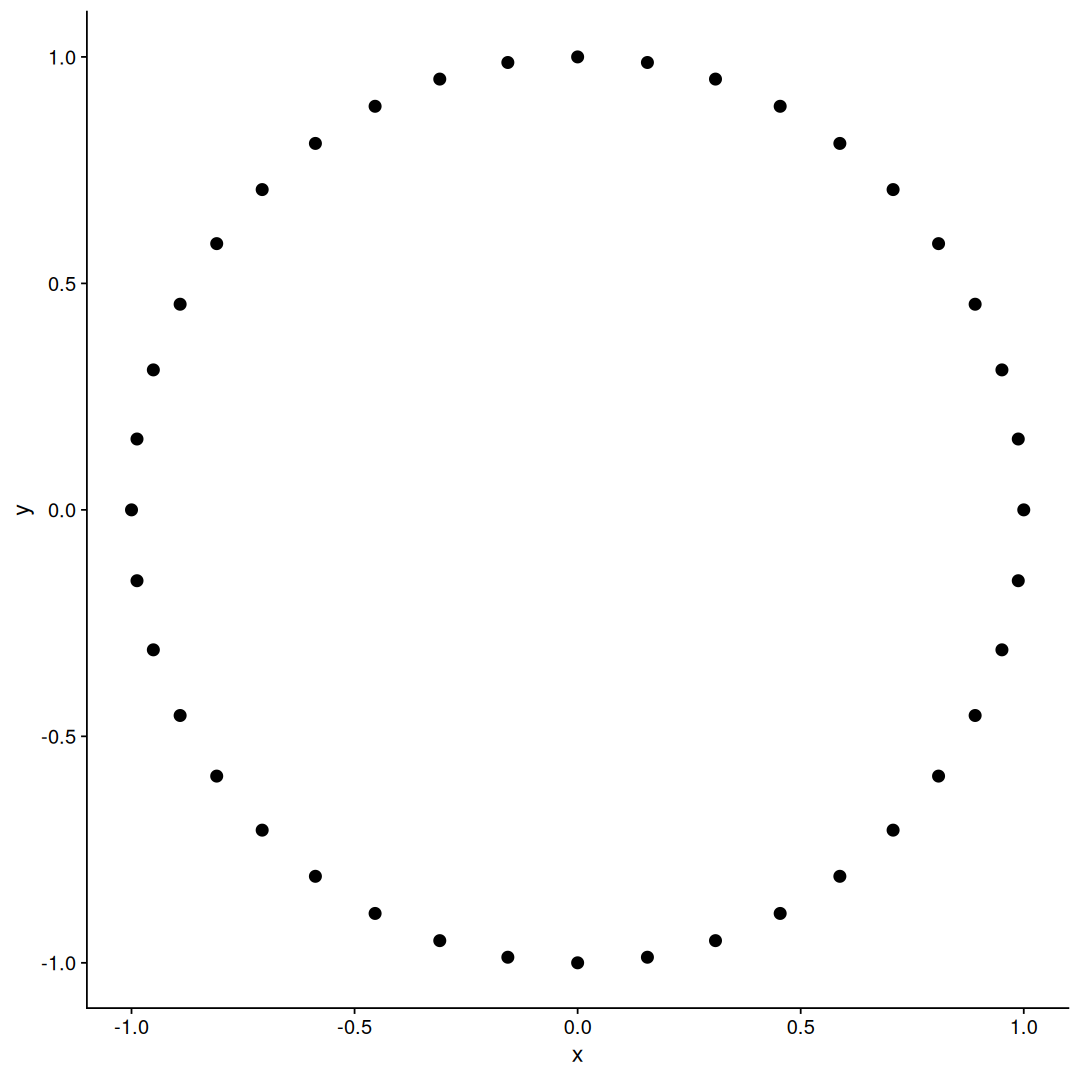

In [5]:
circle_points(40) |>
ggplot(aes(x,y)) +
geom_point(size=3)

The `|>` is the pipe operator, if you haven't seen it before, these two lines are equivalent:

```R
first_arg |> f() |> g(second_arg) |> h(another_2nd, and_a_3rd_arg)


h(g(f(first_arg),second_arg), another_2nd, and_a_3rd_arg)
```

The pipe operator allows us to compose a sequence of functions in a readable way.

nice, so the next step is to connect the dots, and `ggplot2` has a few tools to help us with that,
the most commonly used is the `geom_line`:

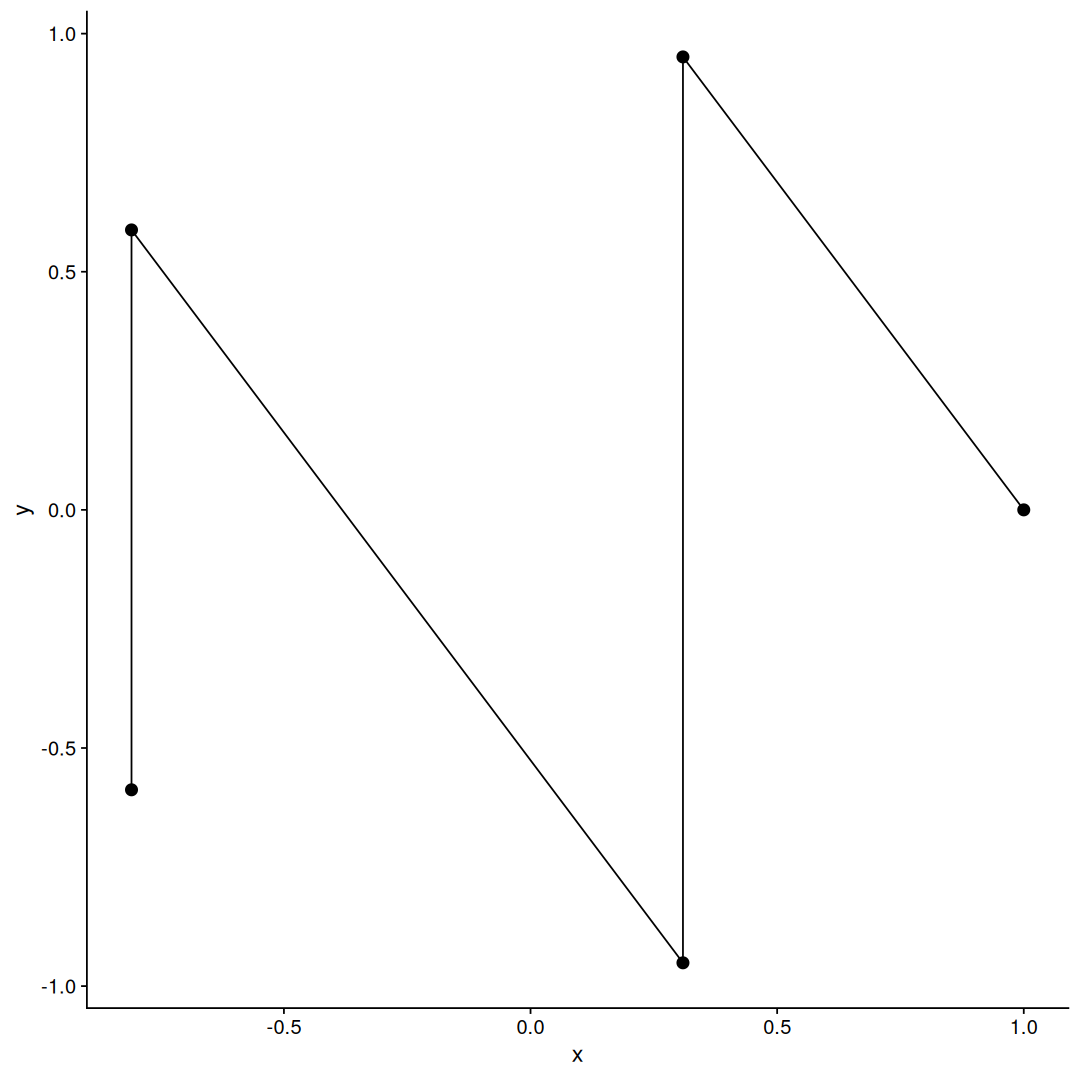

In [6]:
circle_points(5) |>
ggplot(aes(x,y)) +
geom_point(size=3) +
geom_line()

`geom_line` connects the points in the order of the x-axis, this is usually what you want if you have a time series, but not in our case, we want the points to be connected in a specific order we will define, and for that, we can use the `geom_path` instead:

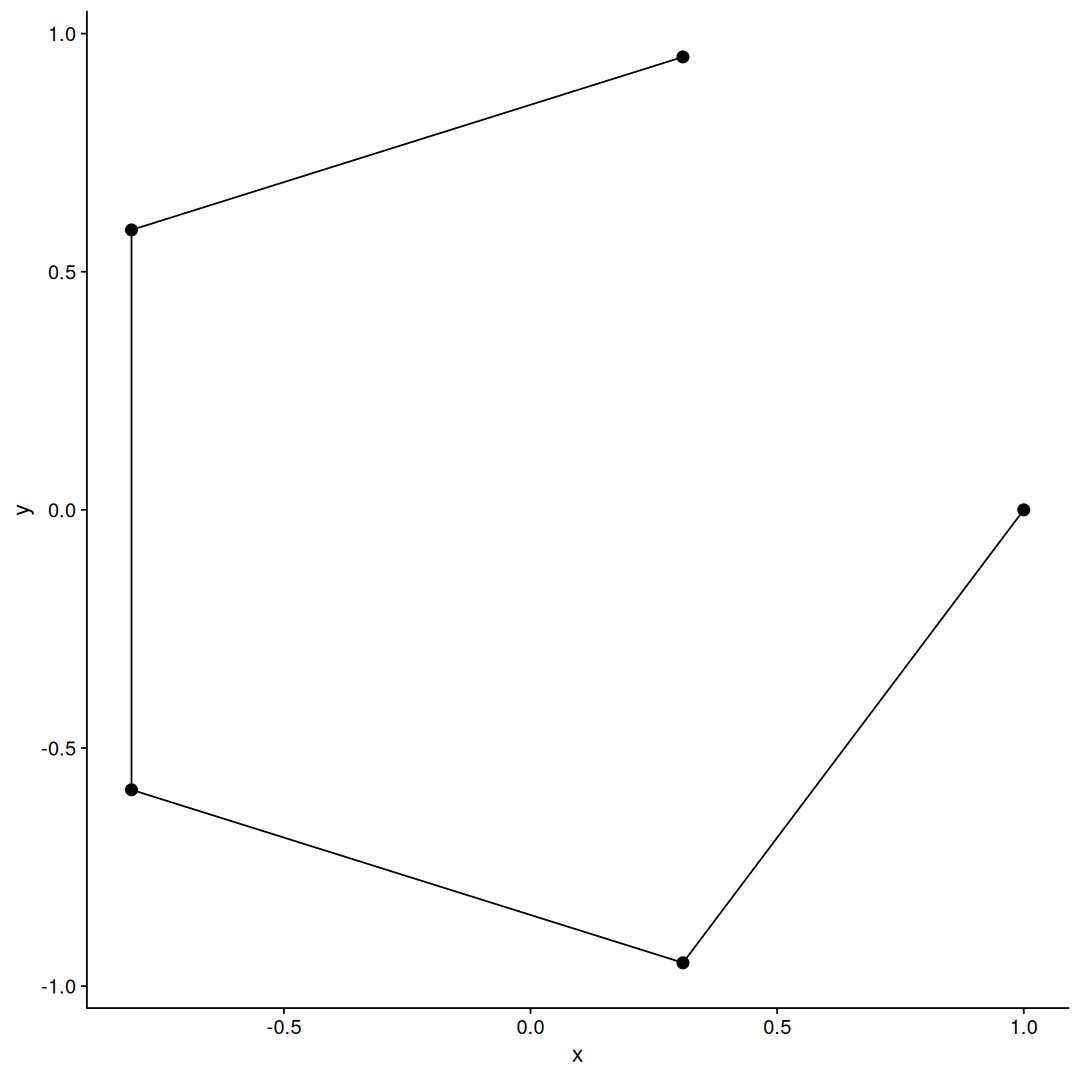

In [7]:
circle_points(5) |>
ggplot(aes(x,y)) +
geom_point(size=3) +
geom_path()

Cool! That is a pentagon, almost, all the points were connected in the same order as they appear in our data frame, however, the last connection is missing, to have that last segment we would need to repeat the first point as the last row on the data frame.

finally, `ggplot2` has another geom that can help us, the aptly named `geom_polygon`!

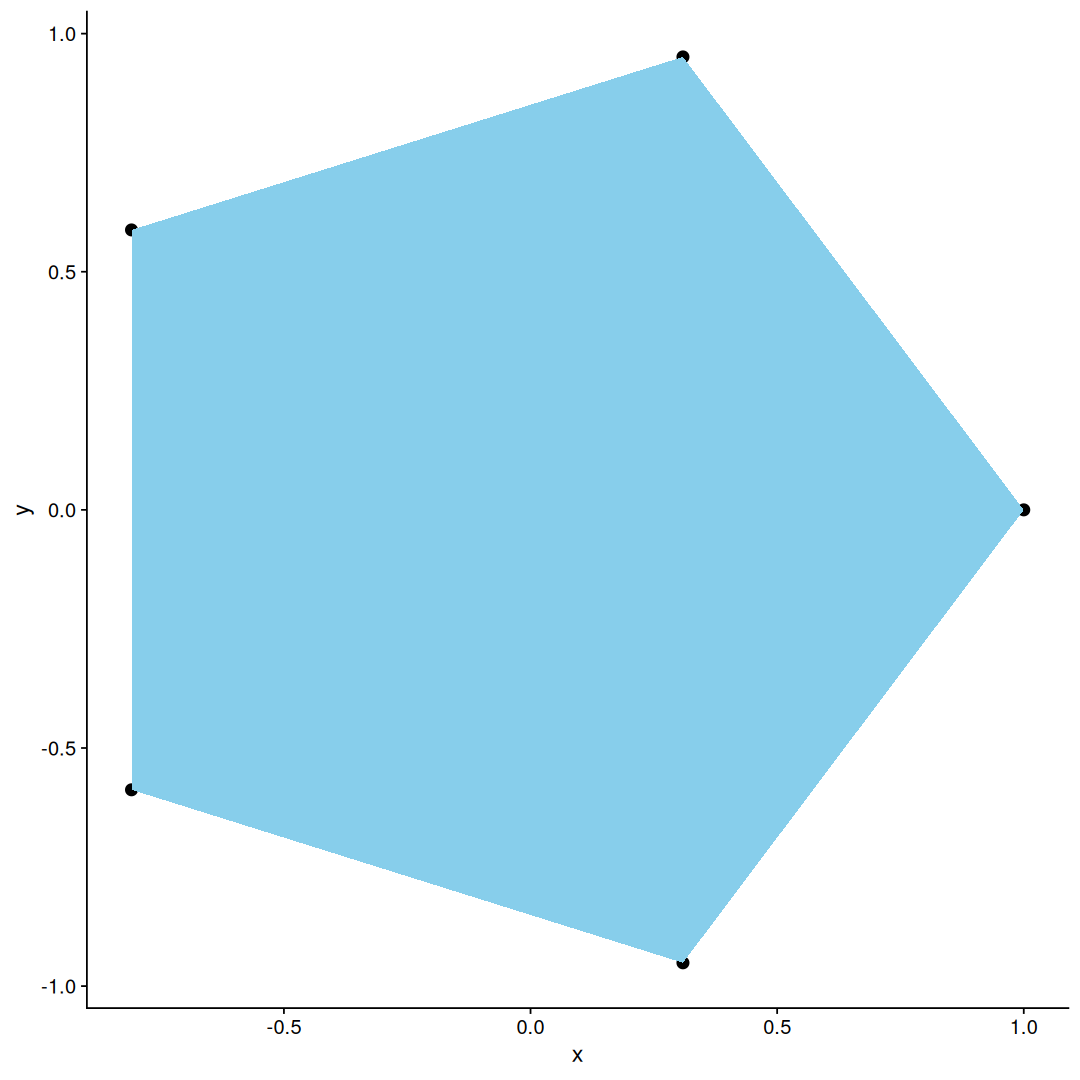

In [8]:
circle_points(5) |>
ggplot(aes(x,y)) +
geom_point(size=3) +
geom_polygon(fill='skyblue')

Now that is a proper pentagon! `geom_polygon` not only connects the ends for us, but it also allows us to fill the shape.

But we aren't here to draw boring convex polygons, so let's go back to `geom_path`, what we need now is to figure out how to re-order our points such that when they are connected they form a star polygon.

If you look back at the pentagram example above, you will see that the points don't connect to their adjacent point, instead they "skip" a point and connect to the next one, the `dplyr` package has a function called `slice` that allows us to take rows from a data frame by their index, using this function we can reorder our points with a vector of indexes:

In [9]:
circle_points(5) |>
slice(c(1,3,5,2,4,1))

N,p,x,y
<dbl>,<int>,<dbl>,<dbl>
5,1,0.309016994374947,9.51056516295154e-01
5,3,-0.809016994374948,-5.87785252292473e-01
5,5,1.000000000000000,-2.44929359829471e-16
5,2,-0.809016994374947,5.87785252292473e-01
5,4,0.309016994374947,-9.51056516295154e-01
5,1,0.309016994374947,9.51056516295154e-01


Note that the last row repeats the first point to complete the path, lets plot this to see how it looks:

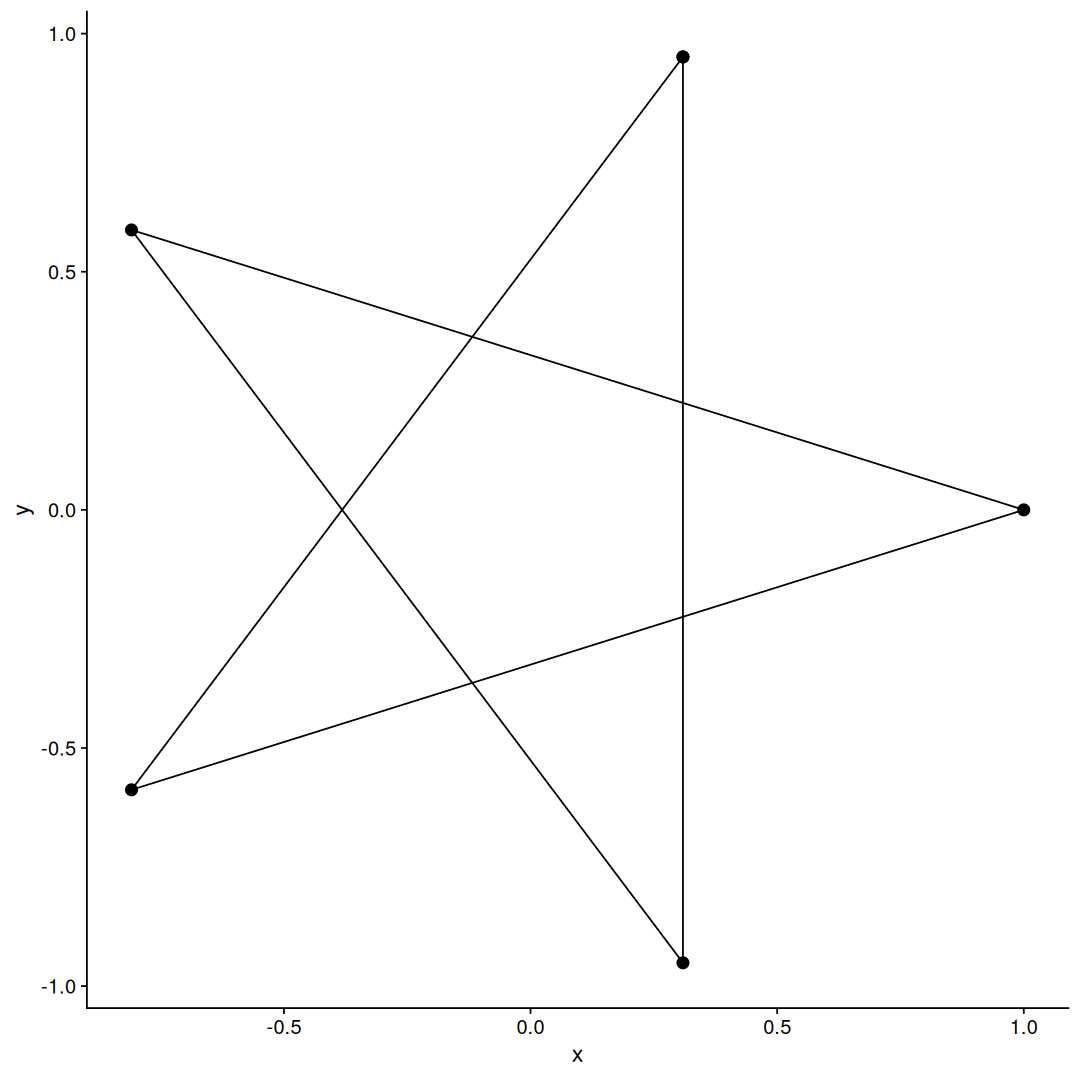

In [10]:
circle_points(5) |>
slice(c(1,3,5,2,4,1)) |>
ggplot(aes(x,y)) +
geom_point(size=3) +
geom_path()

and there we go, a pentagram! 

now, what if we wanted to draw a star polygon with 7 points? or 29 points? I'm too lazy to figure out the point order by hand, so let's try to generalize this.

We need to write a function that returns `N+1` points in the order they need to be connected, skipping a point.

The `accumulate` function from the `purrr` package allows us to sequentially apply a function to a vector and return intermediary results, with some math we can use it to return the points in the order that we want:

In [11]:
# note: %% is the modulo operator
1:5 |> accumulate(function(acc,i) { (acc+1)%%5 + 1 }, .init=1)

[1] 1 3 5 2 4 1

Looks good, let's turn this into a function and give it a try:

In [12]:
star_path_reorder <- function(points) {
    path_order <- 
        1:nrow(points) |>
        accumulate(function(acc,i) { (acc+1)%%nrow(points) + 1 }, .init=1)
    points |>
    slice(path_order)
}

This function takes a data frame of points, reorders and returns them.

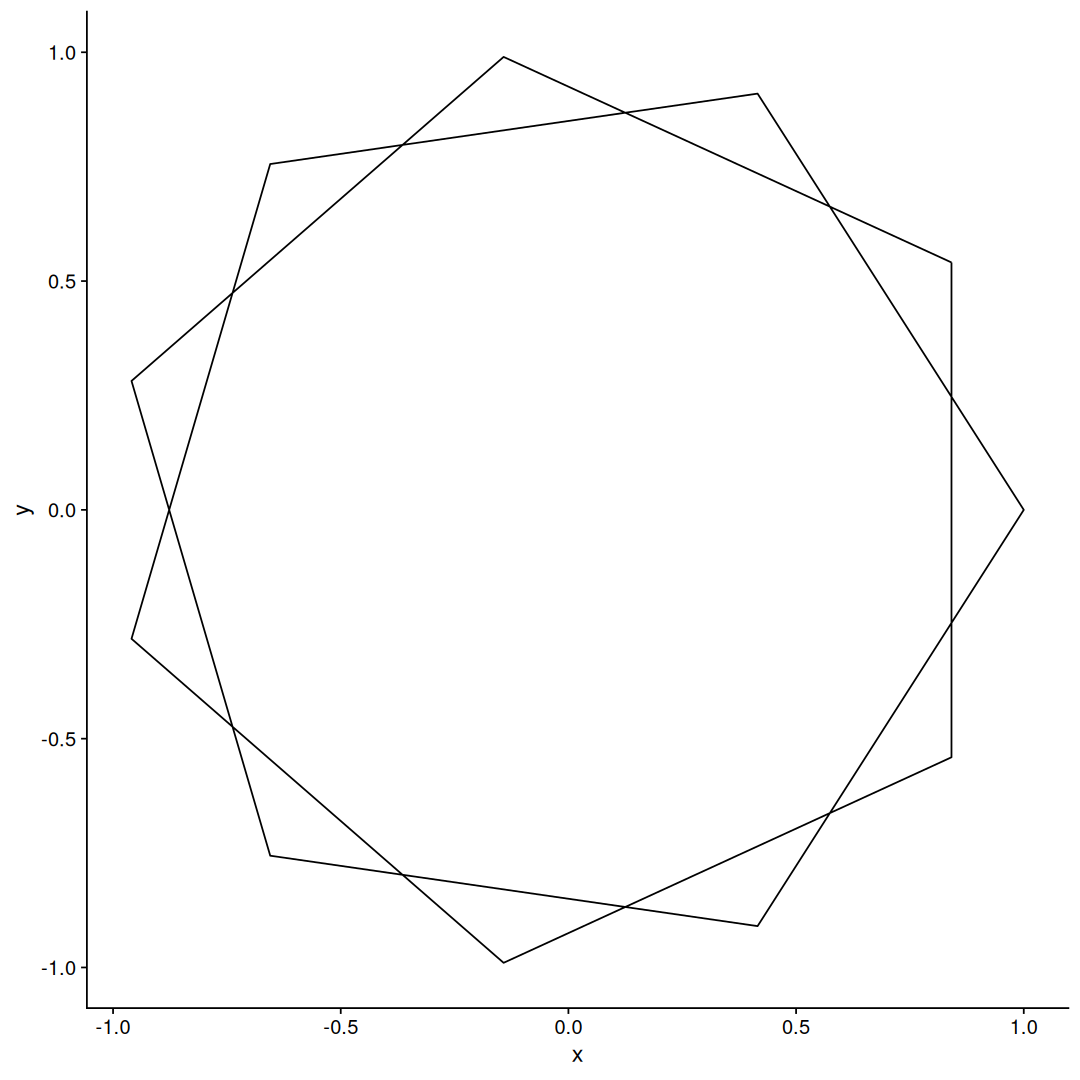

In [13]:
circle_points(11) |>
star_path_reorder() |>
ggplot(aes(x,y)) +
geom_path()

A 11-point star polygon ! it works !!

However, there is more than one way to draw an 11-point star polygon, there are 4 different ways in fact, and we can get these different ways by varying how many points we "skip", so we need to modify our function to allow for this:

In [14]:
star_path_reorder <- function(points, d) {
    path_order <- 
        1:nrow(points) |>
        accumulate(function(acc,i) { (acc+d-1)%%nrow(points) + 1 }, .init=1)
    points |>
    slice(path_order)
}

`d` is the [density](https://en.wikipedia.org/wiki/Density_(polytope)).

Let's give it a try with a few different values for `d`:

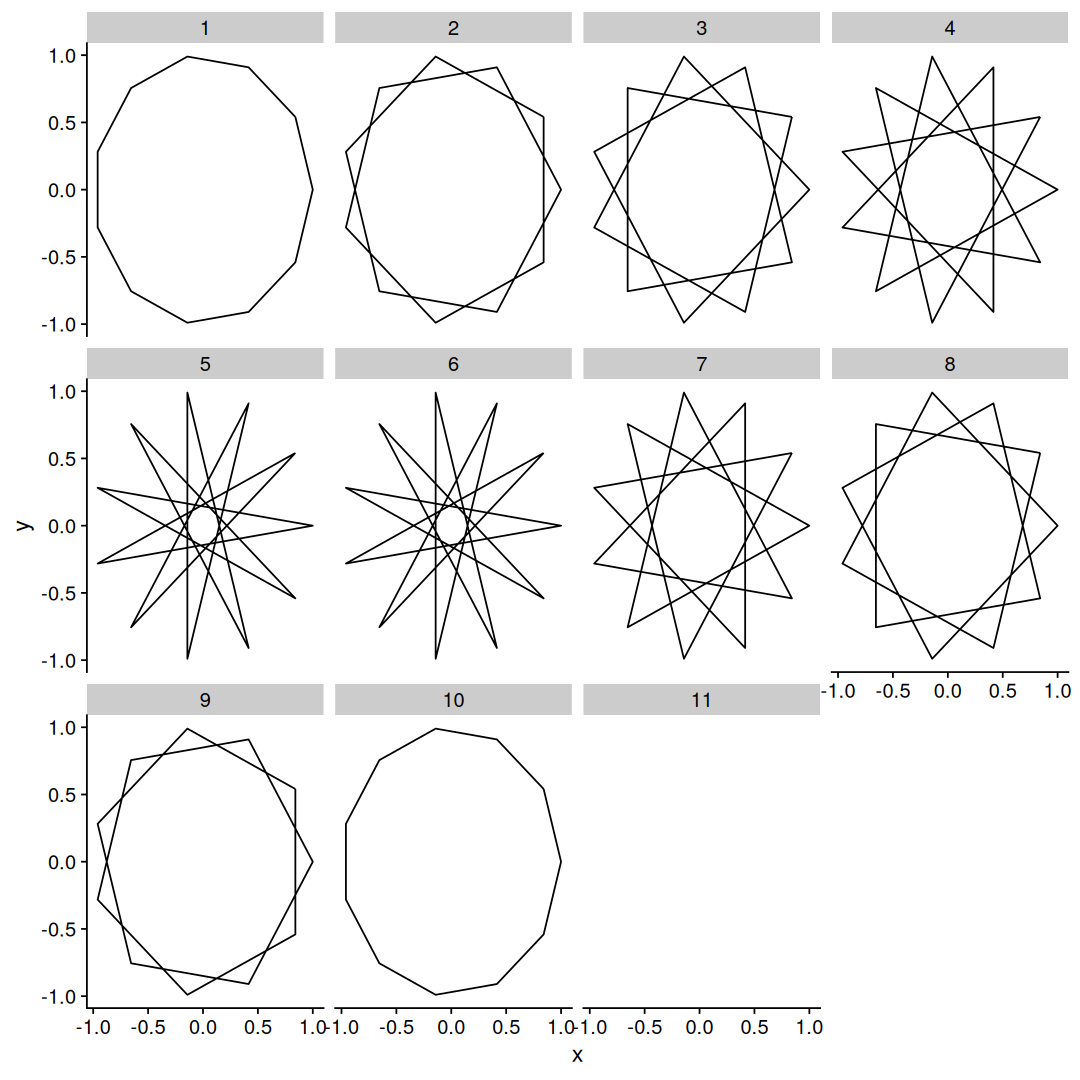

In [15]:
map_df(1:11, function(d) {
    circle_points(11) |>
    star_path_reorder(d) |>
    mutate(d=d)
}) |>
ggplot(aes(x,y)) +
geom_path() +
facet_wrap(~d)

We used `map_df` from the `purrr` package to map over the vector `1:11`, we are generating 11-star points for each value of `d`, and then we plot all of them with ggplot2 `facet_wrap`, which allows us to generate subplots for each value of `d`.

With `d=1` we get a boring undecagon, with `d=2` we get the same results as before, and with `d=3,4,5` we get new stars ! but then something interesting happens, with `d=6` we get the same shape as `d=5`, and `d=7` is the same as `d=4`, and so on.

There is a symmetry here, so we don't need to draw all the densities up to `N`, looks like only halfway is enough, let's try a different `N`:

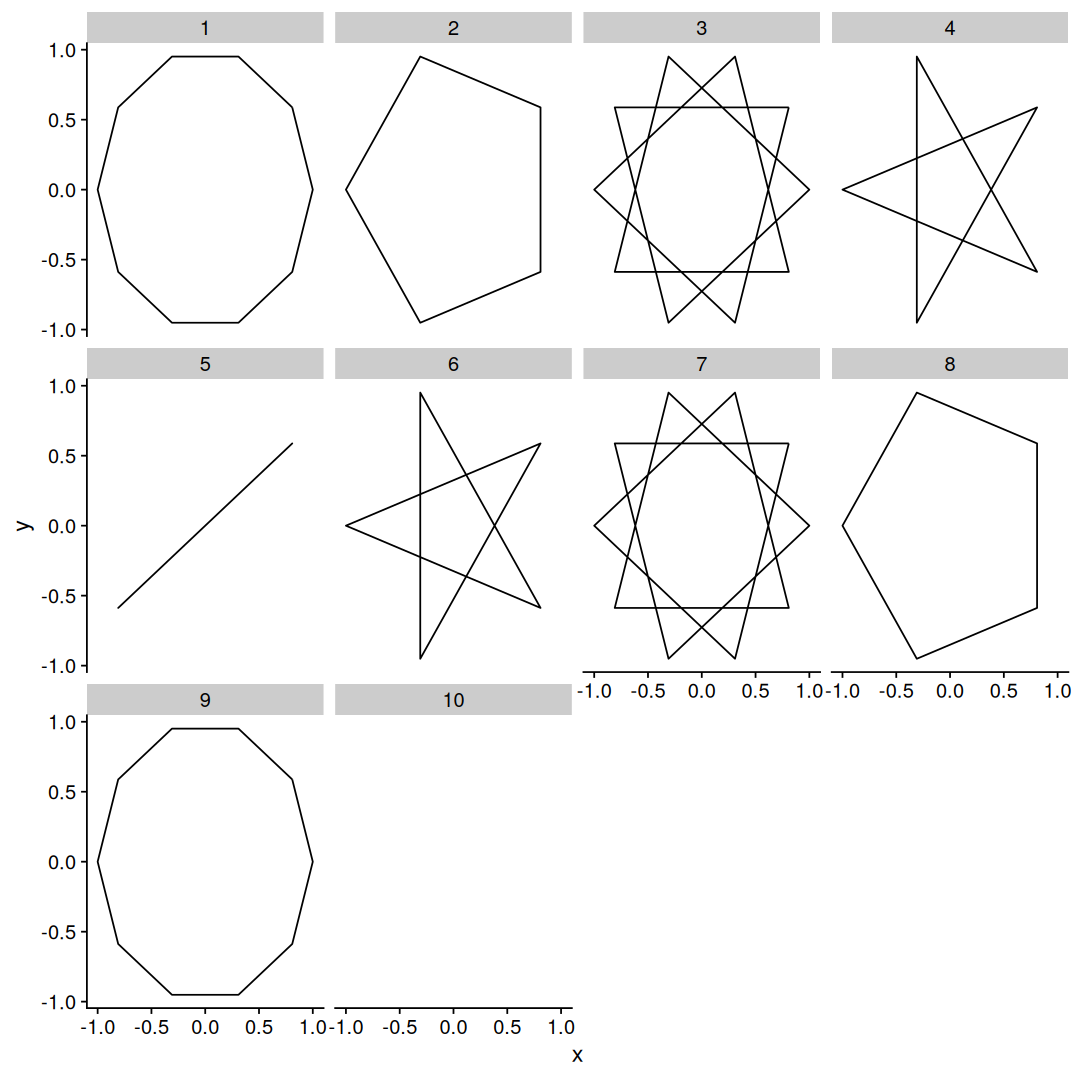

In [16]:
map_df(1:10, function(d) {
    circle_points(10) |>
    star_path_reorder(d) |>
    mutate(d=d)
}) |>
ggplot(aes(x,y)) +
geom_path() +
facet_wrap(~d)

With `N=10` we see a similar pattern, with `d=7` generating the same star polygon as with `d=3`, but there is something else going on here, we got a pentagon with `d=2`, and `d=5` does not even look like a polygon at all.

To draw the star we need a path that goes through all the points, `2` and `5` are divisors of `10`, so it makes sense that we can't get a unicursal path at these densities, but it didn't work for `d=4` either... 

as it turns out, the answer is prime numbers, coprime to be specific, we can only get a star polygon [`{N/d}`](https://en.wikipedia.org/wiki/Schl%C3%A4fli_symbol) if `N` and `d` are coprime, otherwise some points will be left unvisited, so let's make a function that lists all possible densities for a star polygon `N`:

In [17]:
library(primes)

star_densities <- function(N) {
    2:(N/2) |>
    keep(partial(coprime, N))
}

once again, `keep` and `partial` are functions from the `purrr` package, `keep` will filter the vector with a given function, and `partial` partially applies a function with the given argument,

we are testing all numbers from `2` to `N/2` and *keeping* only the coprimes with `N`

In [18]:
star_densities(10)

[1] 3

In [19]:
star_densities(11)

[1] 2 3 4 5

naturally, for prime numbers like `11`, any number between `2` and `N/2` will work.

armed with this, we can now build a function that will generate all star polygons with `N` points:

In [20]:
generate_star_paths <- function(N) {
    star_densities(N) |>
    map_df(function(d) {
        circle_points(N) |>
        star_path_reorder(d) |>
        mutate(d=d)
    })
}

and plot them like so:

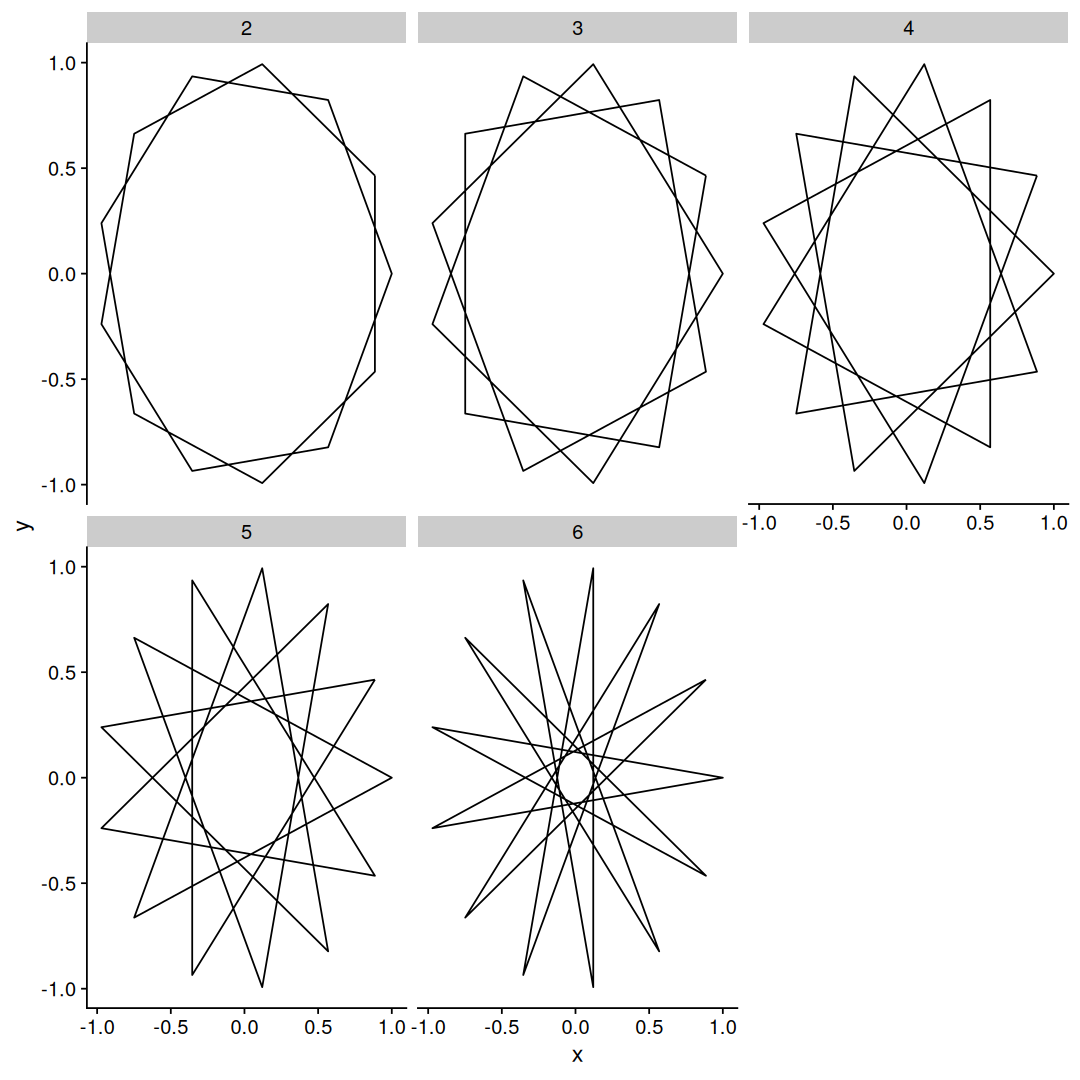

In [21]:
generate_star_paths(13) |>
ggplot(aes(x,y)) +
geom_path() +
facet_wrap(~d)

and building on that, we can also generate star polygons for many `N` at once:

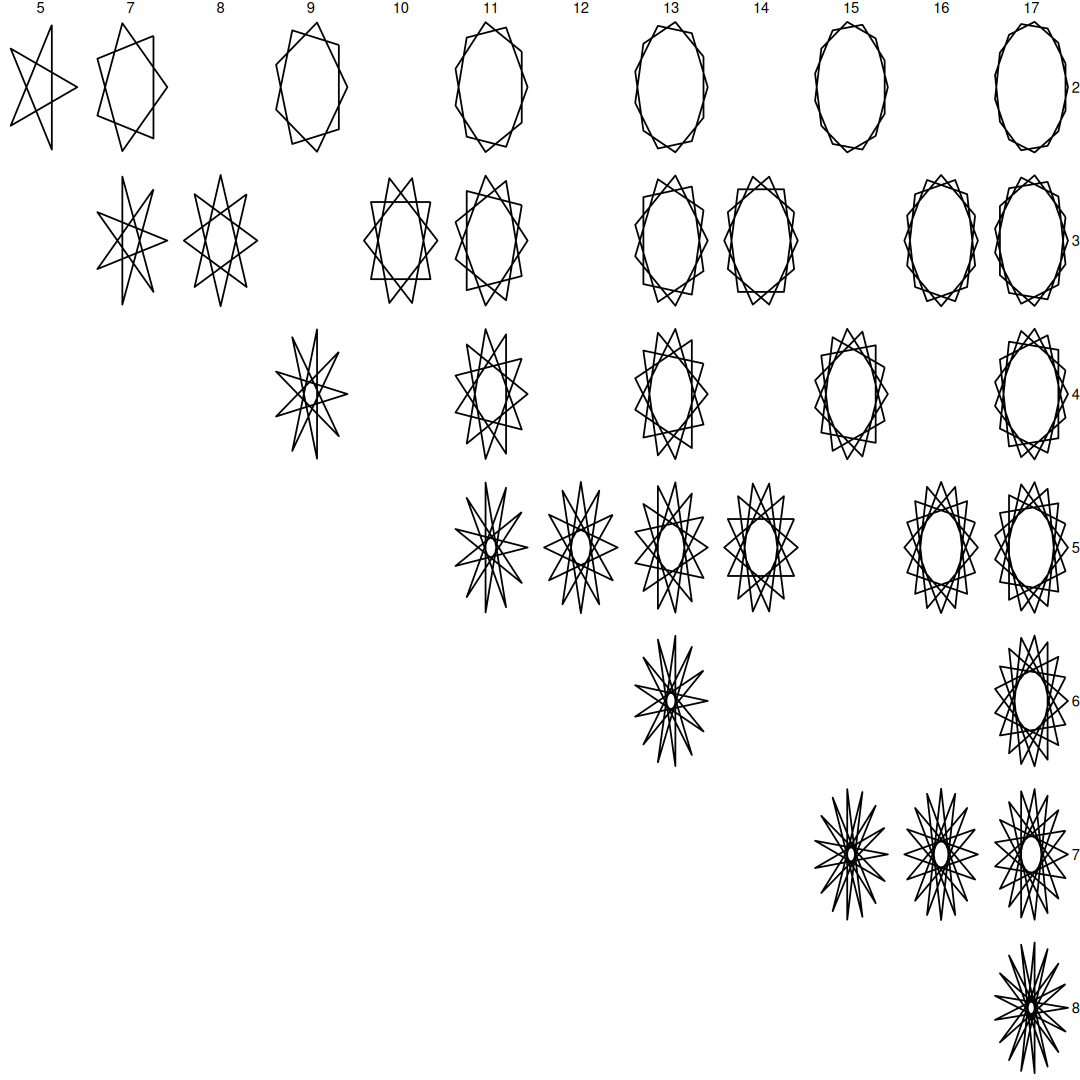

In [22]:
map_df(5:17, generate_star_paths) |>
ggplot(aes(x,y)) +
geom_path() +
facet_grid(d~N) +
theme_void()

`facet_grid` makes a 2D grid of subplots with `N` along the horizontal axis and `d` along the vertical axis, also I used `theme_void()` to save some space on the figure.

**Bonus**: not every `N` has a regular star polygon, `6` is an example of this since `2` and `3` are divisors of `6`:

In [23]:
star_densities(6)
# no results :(

integer(0)

but `6` is special in other ways, because there is another type of unicursal 6-point star polygon:

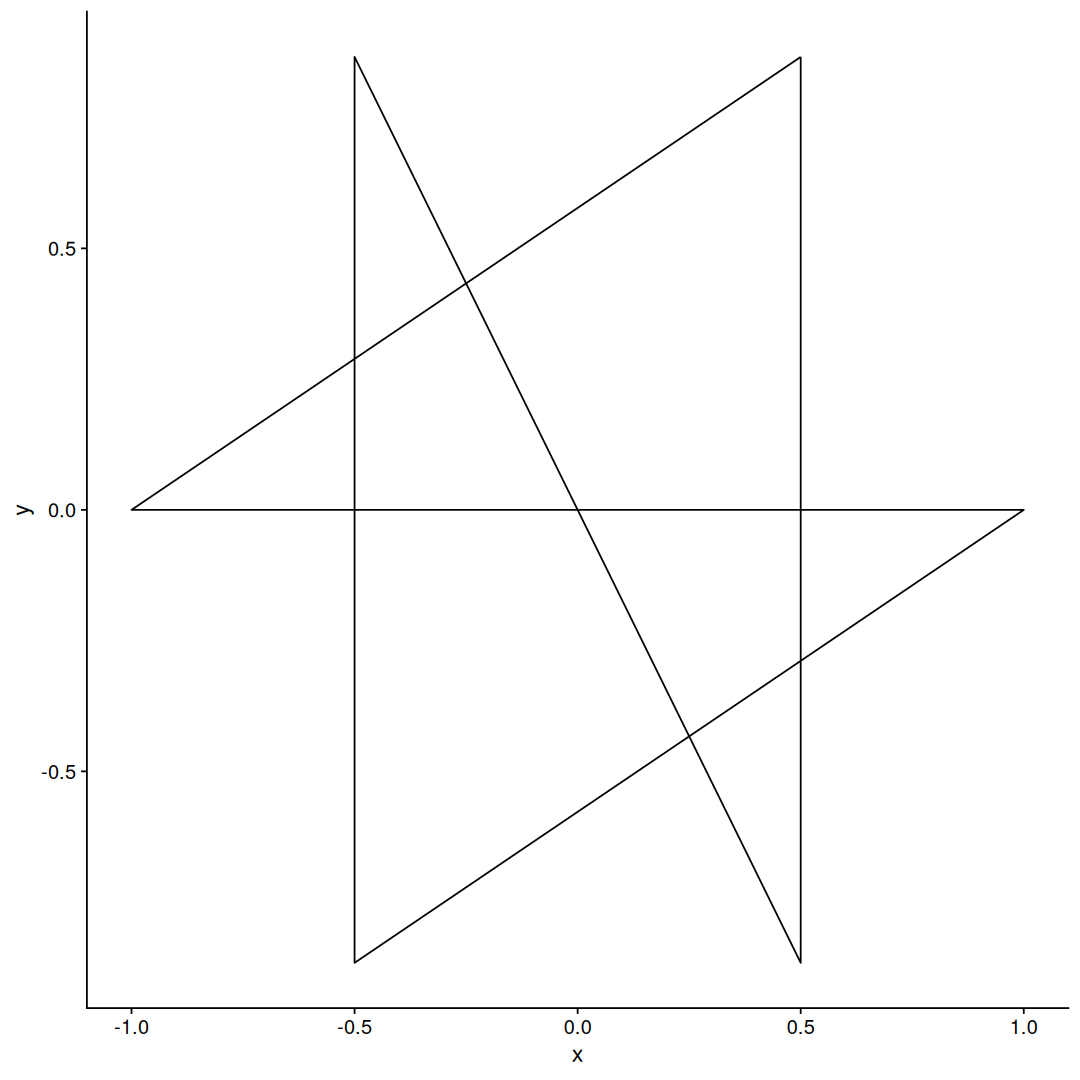

In [24]:
circle_points(6) |>
slice(c(1,3,6,4,2,5,1)) |>
ggplot(aes(x,y)) +
geom_path()

This one is different because the number of "skipped" points varies from one point to the next, but there is a pattern to it, see if you can figure it out.

**Bonus 2**: Coloring the star

So far we only drew the skeleton of the star, we can make it look nicer by adding some colors:

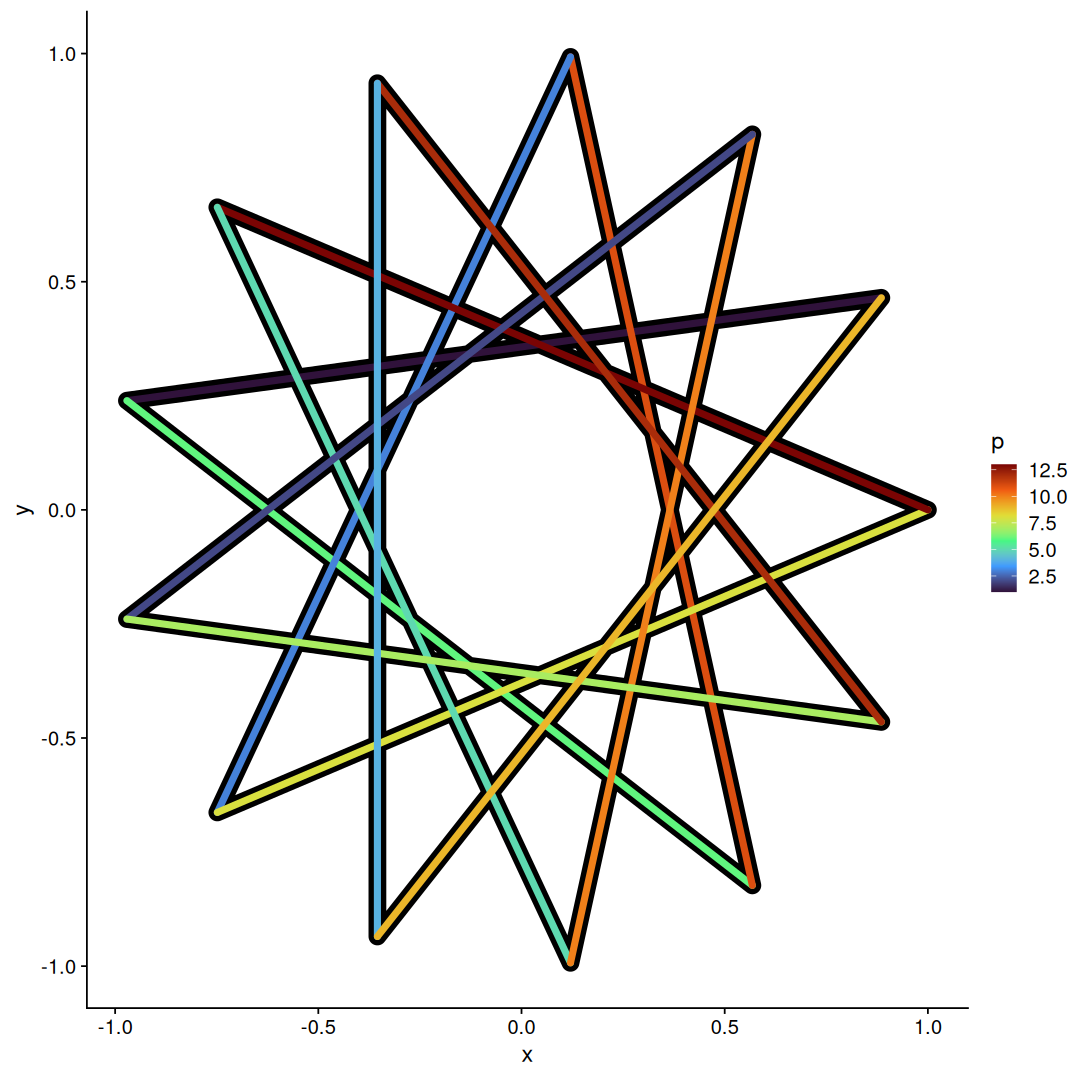

In [25]:
circle_points(13) |>
star_path_reorder(5) |>
ggplot(aes(x,y)) + 
geom_path(linewidth=5, lineend='round') +
geom_path(aes(color=p),linewidth=2, lineend='round') +
scale_color_viridis_c(option='turbo')

Note that we call `geom_path` two times, to create the border effect we are actually drawing the star twice, first thicker in black then thinner with different colors for each line.

However the effect does not quite work as intended because all the colors are draw after the black lines, 

to fix this we need to change how we are drawing it, instead of a list of points we can instead generate a list of segments, this allows more control on how each segment is draw.

First, to convert the list of points into segments we can use `dplyr::lead`, which gives us access to the value of the next row.

In [26]:
star_segments <-
    circle_points(13) |>
    star_path_reorder(5) |>
    # xend,yend is the x,y of the next row
    mutate(xend=lead(x), yend=lead(y)) |>
    # omits the last row, because the next to last row is already connecting the last point
    na.omit()

head(star_segments)

N,p,x,y,xend,yend
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
13,1,0.885456025653210,4.64723172043769e-01,-0.970941817426052,2.39315664287558e-01
13,6,-0.970941817426052,2.39315664287558e-01,0.568064746731155,-8.22983865893657e-01
13,11,0.568064746731155,-8.22983865893657e-01,0.120536680255323,9.92708874098054e-01
13,3,0.120536680255323,9.92708874098054e-01,-0.748510748171101,-6.63122658240795e-01
13,8,-0.748510748171101,-6.63122658240795e-01,1.000000000000000,6.43249059870655e-16
13,13,1.000000000000000,6.43249059870655e-16,-0.748510748171101,6.63122658240795e-01


Now we can use `geom_segment` to plot our segments:

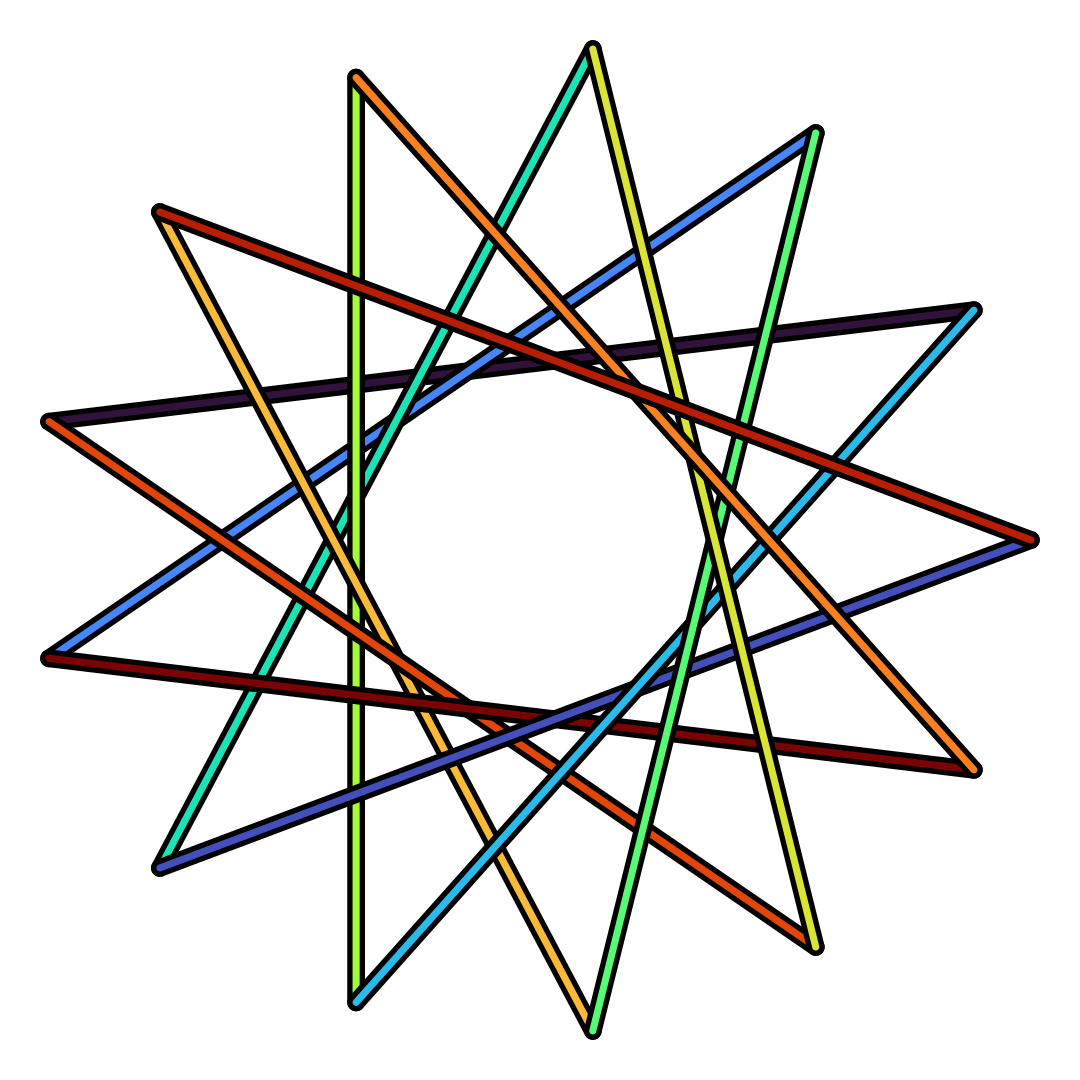

In [27]:
star_segments |>
# every row is repeated for size 5 and 2
crossing(sz = c(5,2)) |>
# map line sizes to colors
mutate(col=ifelse(sz==5, 'black', viridis::turbo(13))) |>
arrange(p,desc(sz)) |>
ggplot(aes(x,y, xend=xend, yend=yend)) +
geom_segment(aes(linewidth=sz, color=col), lineend='round') +
scale_linewidth_identity() +
scale_color_identity() +
theme_void()

**Bonus 3**: bezier star polygons

In [28]:
library(ggforce)

Its not possible not draw a 3-point star polygon, you only get a triangle, however if relax the constraint of using only straight lines:

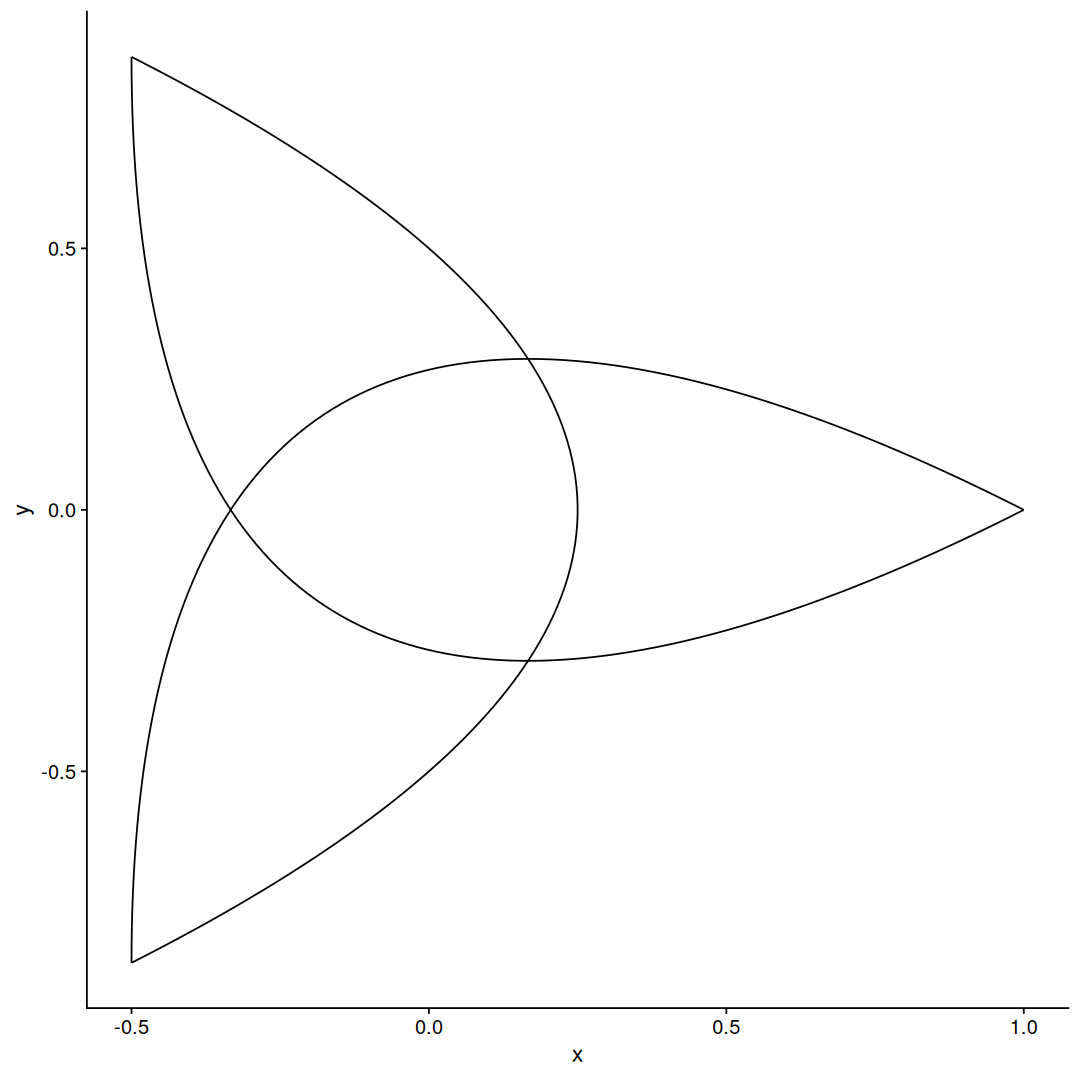

In [29]:
circle_points(3) |>
slice(c(1,2,3,3,1,2,2,3,1)) |>
mutate(g=sort(rep(1:3, 3))) |>
ggplot(aes(x,y,group=g)) +
geom_bezier()

We get a shape that looks similar to a [Triquetra](https://en.wikipedia.org/wiki/Triquetra) or a [Trefoil knot](https://en.wikipedia.org/wiki/Trefoil_knot)

In [30]:
star_bezier_reorder <- function(points) {
    path <-
        1:(nrow(points)-1) |> 
        accumulate(function (r,x) { z<-tail(r,1); (c(z-1,z,z+1) %% nrow(points))+1 }, .init=1:3) |>
        list_c()
    points |>
    slice(path) |>
    mutate(group=sort(rep(1:nrow(points), 3)))
}

In [31]:
star_bezier2_reorder <- function(points) {
    path <-
        1:(nrow(points)-1) |> 
        accumulate(function (r,x) { z<-tail(r,1); (c(z-1,z,z+1,z+2) %% nrow(points))+1 }, .init=1:4) |>
        list_c()
    points |>
    slice(path) |>
    mutate(group=sort(rep(1:nrow(points), 4)))
}

In [32]:
star_bezier3_reorder <- function(points, d) {
    if(d %% 2 == 0) {
        path <-
            1:nrow(points) |> 
            accumulate(function (r,x) { z<-tail(r,1); (c(z-1,z+d-2,z+d-1) %% nrow(points))+1 }, .init=1) |>
            tail(-1) |>
            list_c()
        points |>
            slice(path) |>
            mutate(group=sort(rep(1:nrow(points), 3)), d=d)
    } else {
        path <-
            1:nrow(points) |> 
            accumulate(function (r,x) { z<-tail(r,1); (c(z-1,z+d-3,z+d-2,z+d-1) %% nrow(points))+1 }, .init=1) |>
            tail(-1) |>
            list_c()
        points |>
            slice(path) |>
            mutate(group=sort(rep(1:nrow(points), 4)), d=d)
    }
}

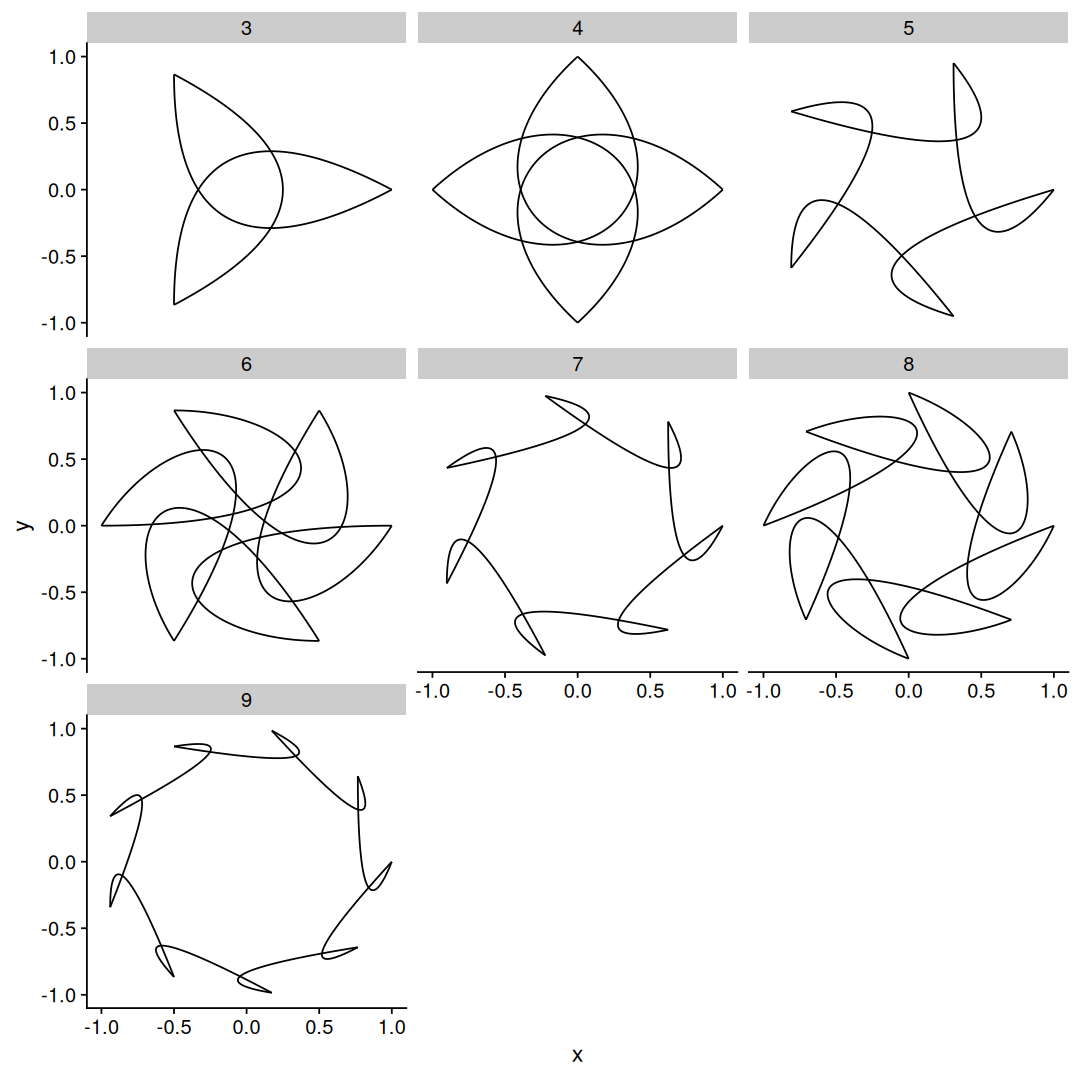

In [33]:
map_df(3:9, function(N) {
    circle_points(N) |>
    star_bezier3_reorder(N-1)
}) |>
ggplot(aes(x,y,group=group)) +
geom_bezier() +
facet_wrap(~N)

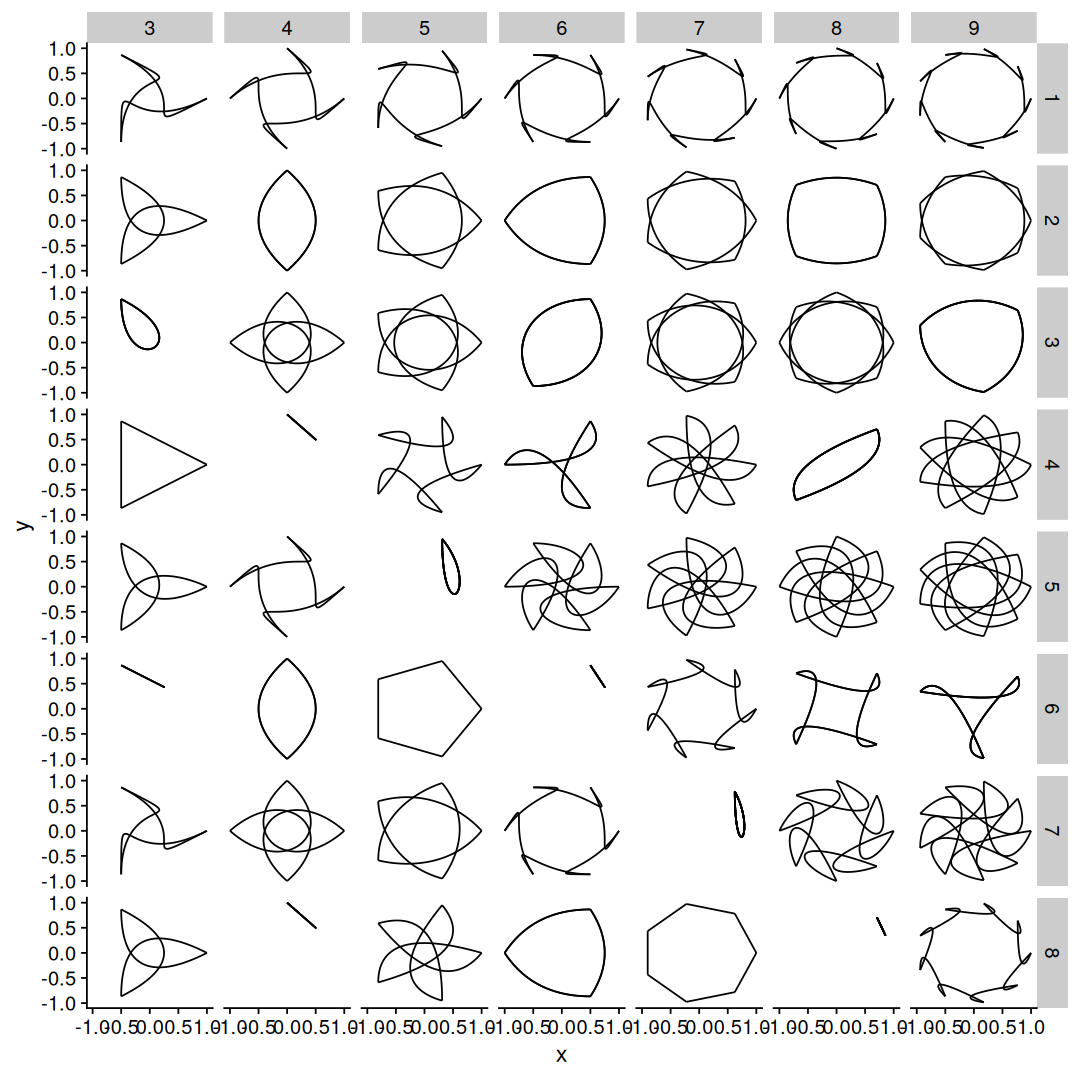

In [34]:
map_df(3:9, function(N) {
    map_df(1:8, function(d) {
        circle_points(N) |>
        star_bezier3_reorder(d)
    })
}) |>
ggplot(aes(x,y,group=group)) +
geom_bezier() +
facet_grid(d~N)